# Distance-of-Distances Analysis: Comprehensive Overview

This notebook systematically computes all available **distance-of-distances measures** for comparing ultrametric (hierarchical) brain network structures across experimental phases.

## Workflow
1. **Load data** for all patients and phases
2. **Build correlation networks** with appropriate thresholding per patient/phase/band
3. **Perform LRG hierarchical clustering** to obtain ultrametric matrices and linkage structures
4. **Compute distance-of-distances** using multiple measures:
   - Ultrametric Matrix Distance
   - Ultrametric Scaled Distance
   - Ultrametric Rank Correlation
   - Ultrametric Quantile RMSE
   - Ultrametric Distance (Permutation Robust)
   - Tree-based measures (Robinson-Foulds, Cophenetic Correlation, Baker's Gamma, Fowlkes-Mallows)
   - Advanced multiscale measures

All intermediate results are stored in dictionaries for efficient memory management.

In [11]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *
#
path_figs = Path('data') / 'figures' / 'new_distance_of_distances'
path_figs.mkdir(parents=True, exist_ok=True)

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### data reader

In [2]:
data_dict, int_label_map = load_data_dict()

## Step 1: Configuration and Setup

Select patient and configure analysis parameters.

In [12]:
# Select patient
patient = 'Pat_02'

# Extract patient data and labels
data_pat = data_dict[patient]
pin_labels = int_label_map[patient]['label']

# Correlation network protocol
correlation_protocol = dict(threshold=0, spectral_cleaning=False)



# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=True)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='top')

print(f"Patient: {patient}")
print(f"Phases: {phase_labels}")
print(f"Bands: {list(BRAIN_BANDS.keys())}")

Patient: Pat_02
Phases: ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
Bands: ['delta', 'theta', 'alpha', 'beta', 'low_gamma', 'high_gamma']


## Step 2: Build Correlation Networks and Perform Hierarchical Clustering

For each phase $\phi$ and band $\beta$:
1. **Filter time series** to frequency band $(f_{\rm low}, f_{\rm high})$
2. **Compute correlation matrix** $C_{ij}^{\phi,\beta}$
3. **Convert to distance matrix** $D_{ij}^{\phi,\beta} = \sqrt{2(1 - C_{ij}^{\phi,\beta})}$
4. **Hierarchical clustering** → linkage matrix $Z^{\phi,\beta}$
5. **Extract ultrametric matrix** $\mathcal{U}^{\phi,\beta}$ from cophenetic distances

In [38]:
# Storage dictionaries for all phases and bands
ultrametric_distances = {}  # U^{phi,beta}
linkage_matrices = {}        # Z^{phi,beta}
cond_dist_matrices = {}      # D^{phi,beta} (condensed distance matrix)
correlation_matrices = {}    # C^{phi,beta}
networks = {}                # Graph objects

print("Building correlation networks and performing hierarchical clustering...")
print("=" * 70)

for phase in PHASE_LABELS:
    print(f"\nPhase: {phase}")
    ultrametric_distances[phase] = {}
    linkage_matrices[phase] = {}
    cond_dist_matrices[phase] = {}
    correlation_matrices[phase] = {}
    networks[phase] = {}
    
    data_pat_phase = data_pat[phase]
    data_pat_phase_ts = data_pat_phase['data']
    
    # Ensure fs is a scalar float, not an array
    fs_raw = data_pat_phase['fs']
    fs = float(np.asarray(fs_raw).flat[0])  # Extract scalar from any nested structure
    
    for band, (low_freq, high_freq) in BRAIN_BANDS.items():
        print(f"  {band:12s} [{low_freq:6.2f} - {high_freq:6.2f} Hz]", end=" ... ")
        
        # Process network for this phase and band
        G, label_dict, lnkgM, clTh, corr_mat, dists = process_network_for_phase(
            data_pat_phase_ts, fs, band, correlation_protocol, pin_labels, filter_order=1
        )
        
        # Store results
        networks[phase][band] = G
        correlation_matrices[phase][band] = corr_mat
        linkage_matrices[phase][band] = lnkgM
        cond_dist_matrices[phase][band] = dists
        ultrametric_distances[phase][band] = extract_ultrametric_matrix(lnkgM, G.number_of_nodes())
        
        print(f"✓ (N={G.number_of_nodes()} nodes)")

print("\n" + "=" * 70)
print("✓ All networks and hierarchical structures computed successfully!")

Building correlation networks and performing hierarchical clustering...

Phase: rsPre
  delta        [  0.53 -   4.00 Hz] ... delta (0.53, 4.0)
  Processing band:  (0.53-4.0 Hz)
0.0033886718749999998


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


✓ (N=117 nodes)
  theta        [  4.00 -   8.00 Hz] ... theta (4.0, 8.0)
  Processing band:  (4.0-8.0 Hz)
0.00390625


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


✓ (N=117 nodes)
  alpha        [  8.00 -  13.00 Hz] ... alpha (8.0, 13.0)
  Processing band:  (8.0-13.0 Hz)
0.0048828125


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


✓ (N=117 nodes)
  beta         [ 13.00 -  30.00 Hz] ... beta (13.0, 30.0)
  Processing band:  (13.0-30.0 Hz)
0.0166015625
✓ (N=117 nodes)
  low_gamma    [ 30.00 -  80.00 Hz] ... low_gamma (30.0, 80.0)
  Processing band:  (30.0-80.0 Hz)
0.048828125
✓ (N=117 nodes)
  low_gamma    [ 30.00 -  80.00 Hz] ... low_gamma (30.0, 80.0)
  Processing band:  (30.0-80.0 Hz)
0.048828125
✓ (N=117 nodes)
  high_gamma   [ 80.00 - 300.00 Hz] ... high_gamma (80.0, 300.0)
  Processing band:  (80.0-300.0 Hz)
0.21484375
✓ (N=117 nodes)
  high_gamma   [ 80.00 - 300.00 Hz] ... high_gamma (80.0, 300.0)
  Processing band:  (80.0-300.0 Hz)
0.21484375
✓ (N=117 nodes)

Phase: taskLearn
  delta        [  0.53 -   4.00 Hz] ... delta (0.53, 4.0)
  Processing band:  (0.53-4.0 Hz)
0.0033886718749999998
✓ (N=117 nodes)

Phase: taskLearn
  delta        [  0.53 -   4.00 Hz] ... delta (0.53, 4.0)
  Processing band:  (0.53-4.0 Hz)
0.0033886718749999998
✓ (N=117 nodes)
  theta        [  4.00 -   8.00 Hz] ... theta (4.0, 8.0)
 

## Step 3: Distance-of-Distances Measures

We now compute all available distance measures to compare ultrametric structures across phases.

### Measure 1: Ultrametric Matrix Distance

**Formula:**
$$d(\mathcal{U}^{(1)}, \mathcal{U}^{(2)}) = \text{dist}(\text{triu}(\mathcal{U}^{(1)}), \text{triu}(\mathcal{U}^{(2)}))$$

where `dist` can be Euclidean, cosine, correlation distance.

**Properties:** Direct comparison of ultrametric values; sensitive to absolute magnitudes.

In [43]:
# Select band for analysis
band = 'theta'
n = len(phase_labels)

# Storage for results
results_matrix_distance = {}

# Compute for different metrics
metrics = ['euclidean', 'cosine', 'correlation']

print(f"Computing Ultrametric Matrix Distance for {band} band...")
for metric in metrics:
    distance_matrix = np.zeros((n, n))
    
    for i, phase_i in enumerate(phase_labels):
        for j, phase_j in enumerate(phase_labels):
            if i != j:
                U1 = ultrametric_distances[phase_i][band]
                U2 = ultrametric_distances[phase_j][band]
                distance_matrix[i, j] = ultrametric_matrix_distance(U1, U2, metric=metric)
    
    results_matrix_distance[metric] = distance_matrix.copy()
    print(f"  {metric:12s}: max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")

print("✓ Ultrametric Matrix Distance computed")

Computing Ultrametric Matrix Distance for theta band...
  euclidean   : max=54.9291, mean=40.2898
  cosine      : max=0.9307, mean=0.7261
  correlation : max=1.0967, mean=0.8952
✓ Ultrametric Matrix Distance computed


### Measure 2: Ultrametric Scaled Distance

**Formula:**
$$d_{\text{scaled}}(\mathcal{U}^{(1)}, \mathcal{U}^{(2)}) = \frac{\|T(\mathbf{u}^{(1)}) - T(\mathbf{u}^{(2)})\|_2}{\|T(\mathbf{u}^{(1)})\|_2 + \|T(\mathbf{u}^{(2)})\|_2}$$

where $T$ is a scale transformation: linear, log, z-score, or rank.

**Properties:** Normalized distance in $[0,1]$; robust to different scales.

In [47]:
results_scaled_distance = {}
scales = ['linear', 'log', 'zscore', 'rank']

print(f"Computing Ultrametric Scaled Distance for {band} band...")
for scale in scales:
    distance_matrix = np.zeros((n, n))
    
    for i, phase_i in enumerate(phase_labels):
        for j, phase_j in enumerate(phase_labels):
            if i != j:
                U1 = ultrametric_distances[phase_i][band]
                U2 = ultrametric_distances[phase_j][band]
                distance_matrix[i, j] = ultrametric_scaled_distance(
                    U1, U2, metric='euclidean', scale=scale, normalize=True
                )
    
    results_scaled_distance[scale] = distance_matrix.copy()
    print(f"  {scale:12s}: max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")

print("✓ Ultrametric Scaled Distance computed")

Computing Ultrametric Scaled Distance for theta band...
  linear      : max=0.7124, mean=0.5688
  log         : max=0.5209, mean=0.3507
  zscore      : max=0.7405, mean=0.6107
  rank        : max=0.3083, mean=0.2309
✓ Ultrametric Scaled Distance computed


### Measure 3: Ultrametric Rank Correlation

**Formula (Spearman):**
$$\rho_s = 1 - \frac{6\sum d_i^2}{m(m^2-1)}, \quad d(\mathcal{U}^{(1)}, \mathcal{U}^{(2)}) = 1 - \rho_s$$

**Formula (Kendall):**
$$\tau = \frac{n_c - n_d}{n_c + n_d}, \quad d(\mathcal{U}^{(1)}, \mathcal{U}^{(2)}) = 1 - \tau$$

**Properties:** Ordinal comparison; robust to monotonic transformations.

In [51]:
from lrgsglib.utils.basic.linalg import ultrametric_rank_correlation

results_rank_correlation = {}
methods = ['spearman', 'kendall']

print(f"Computing Ultrametric Rank Correlation for {band} band...")
for method in methods:
    correlation_matrix = np.zeros((n, n))
    
    for i, phase_i in enumerate(phase_labels):
        for j, phase_j in enumerate(phase_labels):
            if i == j:
                correlation_matrix[i, j] = 1.0
            else:
                U1 = ultrametric_distances[phase_i][band]
                U2 = ultrametric_distances[phase_j][band]
                correlation_matrix[i, j] = ultrametric_rank_correlation(U1, U2, method=method)
    
    # Convert correlation to distance
    distance_matrix = 1 - correlation_matrix
    results_rank_correlation[method] = distance_matrix.copy()
    print(f"  {method:12s}: max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")

print("✓ Ultrametric Rank Correlation computed")

Computing Ultrametric Rank Correlation for theta band...
  spearman    : max=0.7853, mean=0.4849
  kendall     : max=0.8418, mean=0.5679
✓ Ultrametric Rank Correlation computed


### Measure 4: Ultrametric Quantile RMSE

**Formula:**
$$\text{RMSE} = \sqrt{\frac{1}{|\mathcal{Q}|} \sum_{q \in \mathcal{Q}} (Q_1(q) - Q_2(q))^2}$$

where $Q_k(q)$ is the $q$-th quantile of $T(\mathcal{U}^{(k)})$ and $\mathcal{Q} = \{0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0\}$.

**Properties:** Compares distributional profiles across scales.

In [52]:
from lrgsglib.utils.basic.linalg import ultrametric_quantile_rmse

results_quantile_rmse = {}

print(f"Computing Ultrametric Quantile RMSE for {band} band...")
distance_matrix = np.zeros((n, n))

for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i != j:
            U1 = ultrametric_distances[phase_i][band]
            U2 = ultrametric_distances[phase_j][band]
            distance_matrix[i, j] = ultrametric_quantile_rmse(U1, U2, scale='log')

results_quantile_rmse['log'] = distance_matrix.copy()
print(f"  log scale:    max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")
print("✓ Ultrametric Quantile RMSE computed")

Computing Ultrametric Quantile RMSE for theta band...
  log scale:    max=5.7611, mean=3.7408
✓ Ultrametric Quantile RMSE computed


### Measure 5: Ultrametric Distance (Permutation Robust)

**Algorithm:**
1. Apply optimal leaf ordering to both linkage matrices
2. Align to canonical node ordering
3. Compute distance between reindexed ultrametric matrices

**Properties:** Invariant to leaf permutations; handles node label differences.

In [53]:
from lrgsglib.utils.basic.linalg import ultrametric_distance_permutation_robust

results_permutation_robust = {}

print(f"Computing Permutation Robust Distance for {band} band...")
distance_matrix = np.zeros((n, n))

for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i != j:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            D1 = cond_dist_matrices[phase_i][band]
            D2 = cond_dist_matrices[phase_j][band]
            distance_matrix[i, j] = ultrametric_distance_permutation_robust(
                Z1, Z2, D1, D2, pin_labels, metric='euclidean'
            )

results_permutation_robust['euclidean'] = distance_matrix.copy()
print(f"  euclidean:    max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")
print("✓ Permutation Robust Distance computed")

Computing Permutation Robust Distance for theta band...
  euclidean:    max=54.9291, mean=40.2898
✓ Permutation Robust Distance computed


### Measure 6: Robinson-Foulds Distance

**Formula:**
$$RF(T_1, T_2) = \frac{1}{2(n-3)}|S(T_1) \triangle S(T_2)|$$

where $S(T)$ is the set of bipartitions induced by tree $T$.

**Properties:** Counts different tree splits; purely topological; $\in [0,1]$ (normalized).

In [54]:
from lrgsglib.utils.basic.linalg import tree_robinson_foulds_distance

results_robinson_foulds = {}

print(f"Computing Robinson-Foulds Distance for {band} band...")
distance_matrix = np.zeros((n, n))

for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i != j:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            distance_matrix[i, j] = tree_robinson_foulds_distance(Z1, Z2, normalized=True)

results_robinson_foulds['normalized'] = distance_matrix.copy()
print(f"  normalized:   max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")
print("✓ Robinson-Foulds Distance computed")

Computing Robinson-Foulds Distance for theta band...
  normalized:   max=0.2544, mean=0.1930
✓ Robinson-Foulds Distance computed


### Measure 7: Cophenetic Correlation

**Formula:**
$$r_{coph} = \frac{\sum_{i<j}(c_1^{ij} - \bar{c_1})(c_2^{ij} - \bar{c_2})}{\sqrt{\sum_{i<j}(c_1^{ij} - \bar{c_1})^2 \sum_{i<j}(c_2^{ij} - \bar{c_2})^2}}, \quad d = 1 - r_{coph}$$

**Properties:** Linear correlation of cophenetic distances; $\in [-1,1]$.

In [55]:
from lrgsglib.utils.basic.linalg import tree_cophenetic_correlation

results_cophenetic = {}

print(f"Computing Cophenetic Correlation for {band} band...")
correlation_matrix = np.zeros((n, n))

for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i == j:
            correlation_matrix[i, j] = 1.0
        else:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            correlation_matrix[i, j] = tree_cophenetic_correlation(Z1, Z2)

distance_matrix = 1 - correlation_matrix
results_cophenetic['distance'] = distance_matrix.copy()
print(f"  distance:     max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")
print("✓ Cophenetic Correlation computed")

Computing Cophenetic Correlation for theta band...
  distance:     max=1.0967, mean=0.8952
✓ Cophenetic Correlation computed


### Measure 8: Baker's Gamma Index

**Formula:**
$$\gamma = \frac{s_+ - s_-}{s_+ + s_-}, \quad d = 1 - \gamma$$

where $s_+$ = concordant comparisons, $s_-$ = discordant comparisons.

**Properties:** Measures concordance of hierarchical relationships; $\in [-1,1]$.

In [56]:
from lrgsglib.utils.basic.linalg import tree_baker_gamma

results_baker_gamma = {}

print(f"Computing Baker's Gamma Index for {band} band...")
gamma_matrix = np.zeros((n, n))

for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i == j:
            gamma_matrix[i, j] = 1.0
        else:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            gamma_matrix[i, j] = tree_baker_gamma(Z1, Z2)

distance_matrix = 1 - gamma_matrix
results_baker_gamma['distance'] = distance_matrix.copy()
print(f"  distance:     max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")
print("✓ Baker's Gamma Index computed")

Computing Baker's Gamma Index for theta band...
  distance:     max=0.8166, mean=0.5331
✓ Baker's Gamma Index computed


### Measure 9: Fowlkes-Mallows Index

**Formula:**
$$FM = \sqrt{\frac{TP}{TP + FP} \cdot \frac{TP}{TP + FN}}, \quad d = 1 - FM$$

**Properties:** Geometric mean of precision and recall; $\in [0,1]$.

In [64]:
from lrgsglib.utils.basic.linalg import tree_fowlkes_mallows_index

results_fowlkes_mallows = {}

print(f"Computing Fowlkes-Mallows Index for {band} band...")
fm_matrix = np.zeros((n, n))

for i, phase_i in enumerate(phase_labels):
    for j, phase_j in enumerate(phase_labels):
        if i == j:
            fm_matrix[i, j] = 1.0
        else:
            Z1 = linkage_matrices[phase_i][band]
            Z2 = linkage_matrices[phase_j][band]
            fm_matrix[i, j] = tree_fowlkes_mallows_index(Z1, Z2)

distance_matrix = 1 - fm_matrix
results_fowlkes_mallows['distance'] = distance_matrix.copy()
print(f"  distance:     max={distance_matrix.max():.4f}, mean={distance_matrix[distance_matrix>0].mean():.4f}")
print("✓ Fowlkes-Mallows Index computed")

Computing Fowlkes-Mallows Index for theta band...
  distance:     max=0.1941, mean=0.1445
✓ Fowlkes-Mallows Index computed


## Step 4: Summary and Visualization

Combine all measures and create comprehensive comparison visualizations.

In [65]:
# Combine all results into a single dictionary
all_measures = {
    # Matrix-based distances
    'matrix_euclidean': results_matrix_distance['euclidean'],
    'matrix_cosine': results_matrix_distance['cosine'],
    'matrix_correlation': results_matrix_distance['correlation'],
    
    # Scaled distances
    'scaled_linear': results_scaled_distance['linear'],
    'scaled_log': results_scaled_distance['log'],
    'scaled_zscore': results_scaled_distance['zscore'],
    'scaled_rank': results_scaled_distance['rank'],
    
    # Rank correlations
    'rank_spearman': results_rank_correlation['spearman'],
    'rank_kendall': results_rank_correlation['kendall'],
    
    # Quantile RMSE
    'quantile_rmse': results_quantile_rmse['log'],
    
    # Permutation robust
    'permutation_robust': results_permutation_robust['euclidean'],
    
    # Tree-based measures
    'robinson_foulds': results_robinson_foulds['normalized'],
    'cophenetic_corr': results_cophenetic['distance'],
    'baker_gamma': results_baker_gamma['distance'],
    'fowlkes_mallows': results_fowlkes_mallows['distance'],
}

print(f"\nTotal number of distance measures computed: {len(all_measures)}")
print(f"Band analyzed: {band}")
print(f"Patient: {patient}")
print("\nAll measures:")
for i, measure_name in enumerate(all_measures.keys(), 1):
    print(f"  {i:2d}. {measure_name}")


Total number of distance measures computed: 15
Band analyzed: theta
Patient: Pat_02

All measures:
   1. matrix_euclidean
   2. matrix_cosine
   3. matrix_correlation
   4. scaled_linear
   5. scaled_log
   6. scaled_zscore
   7. scaled_rank
   8. rank_spearman
   9. rank_kendall
  10. quantile_rmse
  11. permutation_robust
  12. robinson_foulds
  13. cophenetic_corr
  14. baker_gamma
  15. fowlkes_mallows


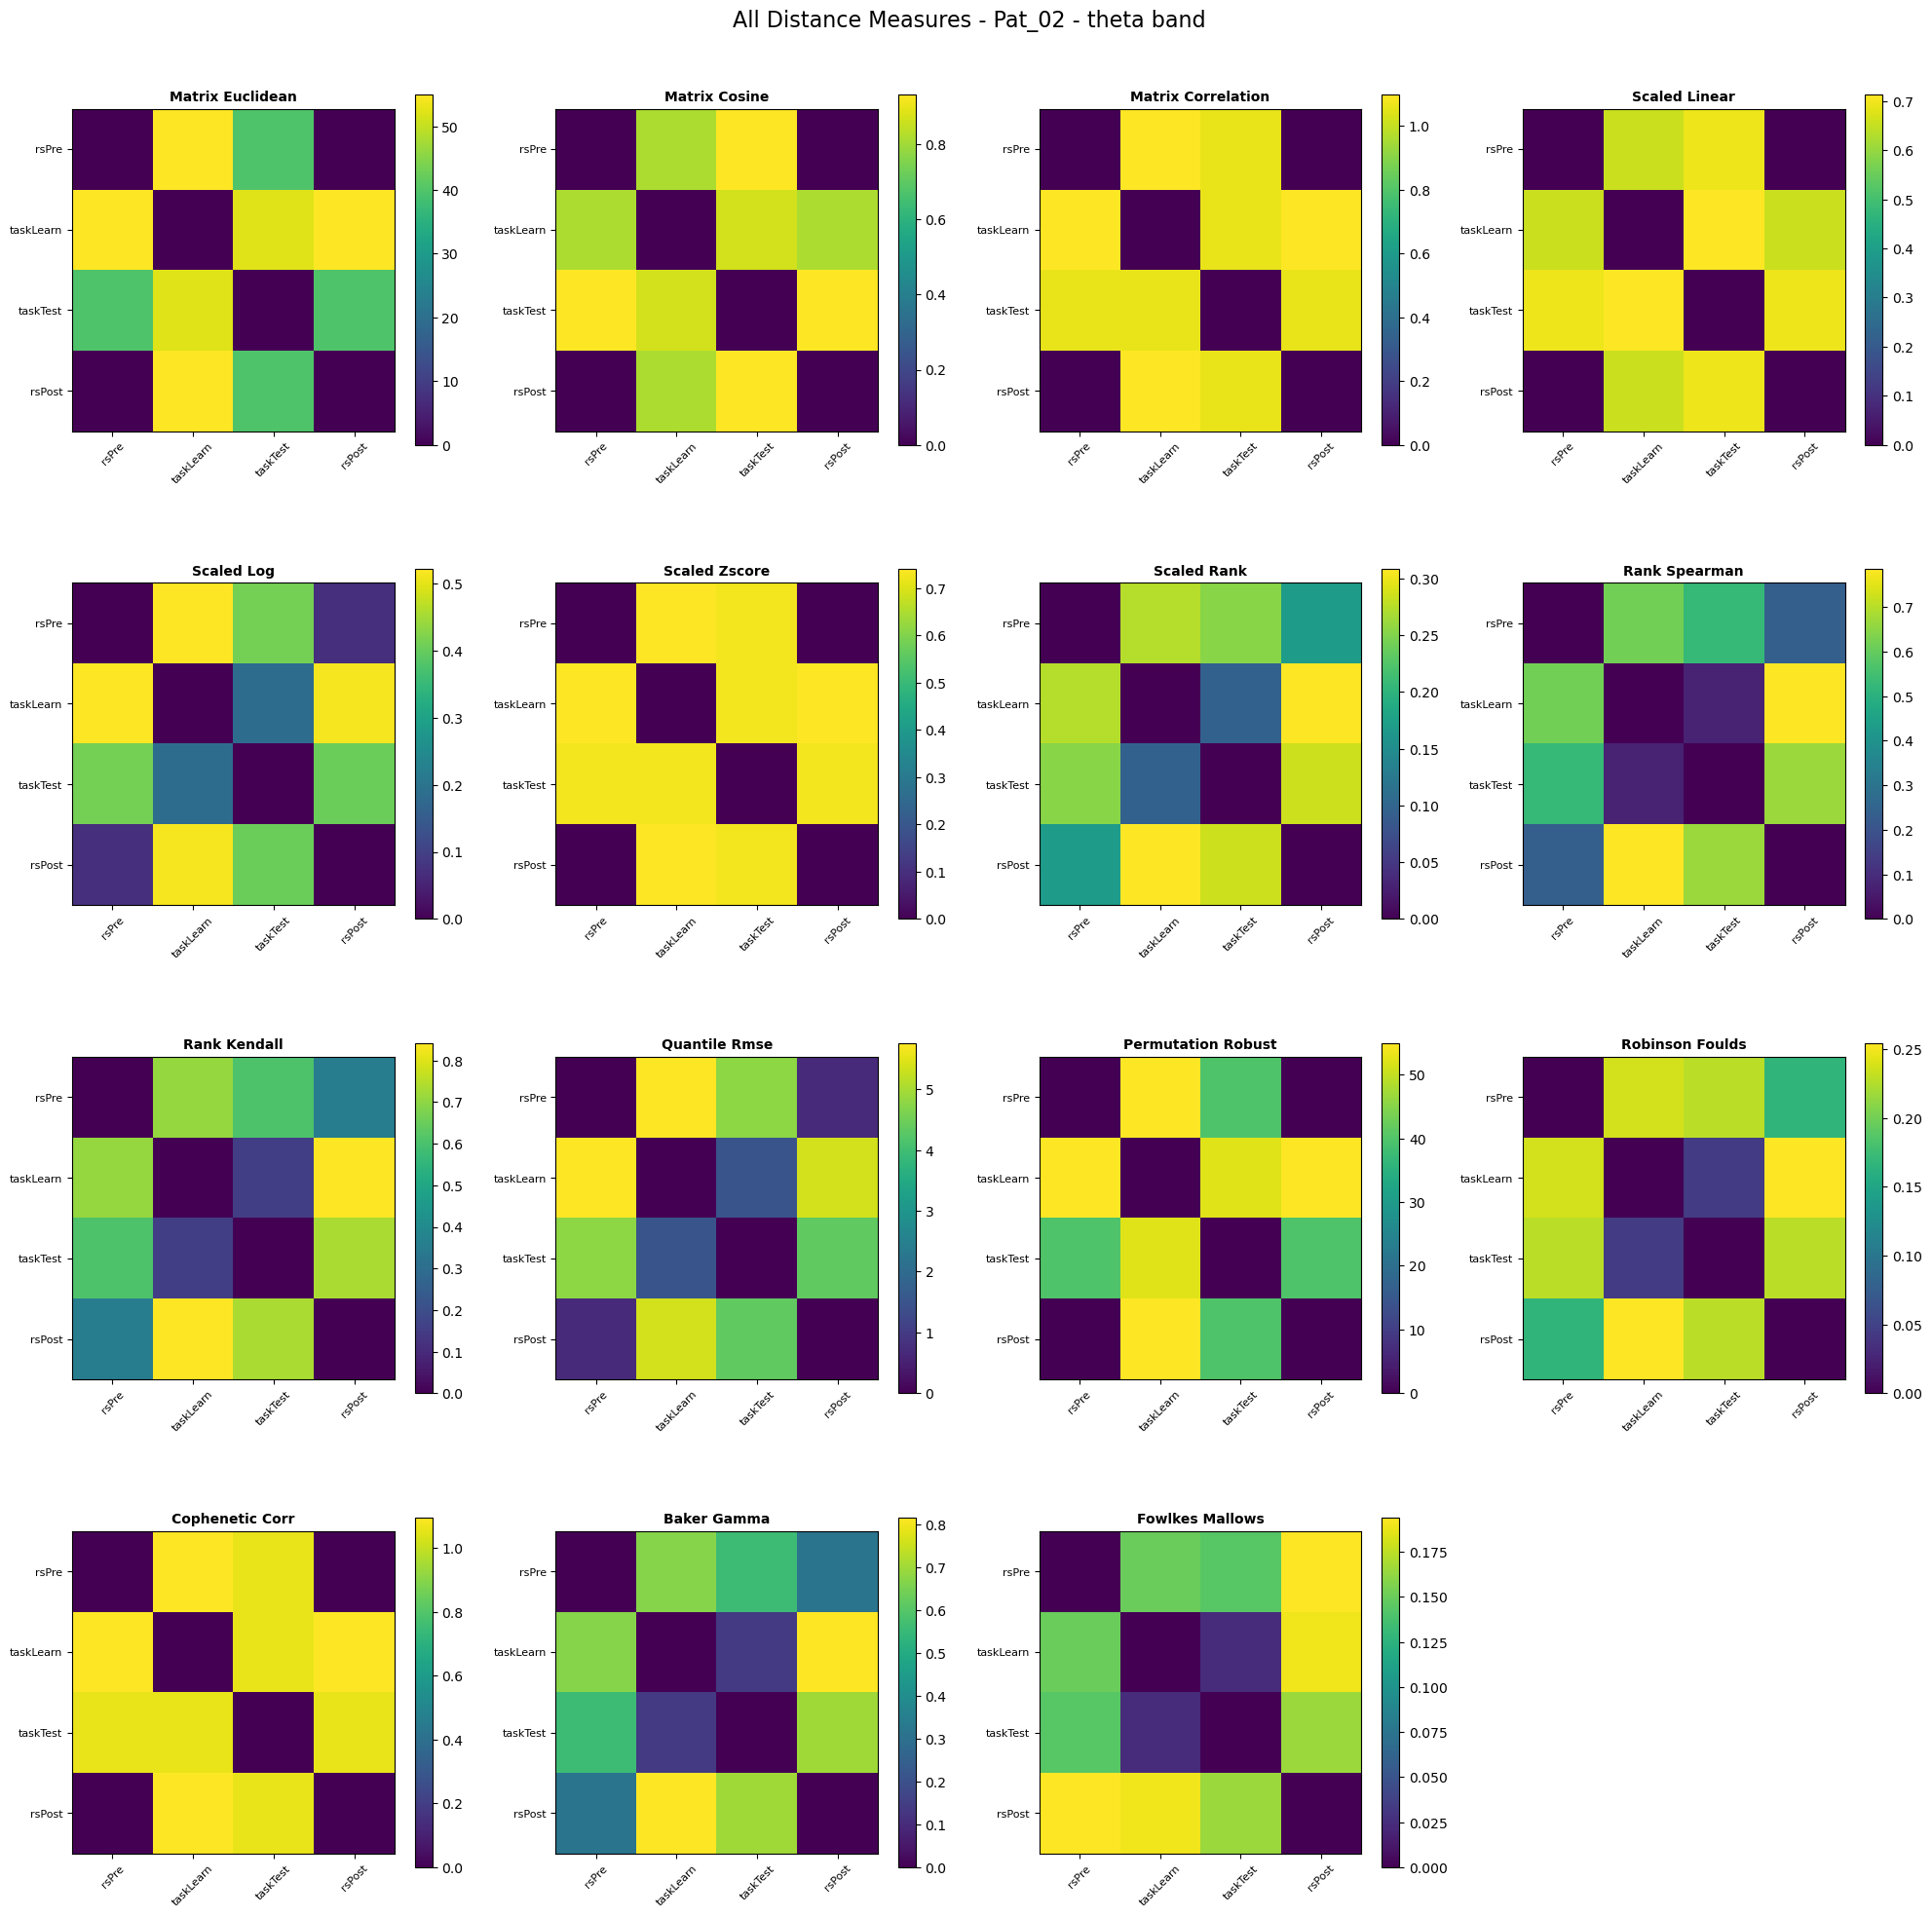

✓ Saved comparison plot to data/figures/new_distance_of_distances/all_measures_Pat_02_theta.png


In [59]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import dendrogram, optimal_leaf_ordering

# Create comprehensive comparison plot of all measures
n_measures = len(all_measures)
n_cols = 4
n_rows = (n_measures + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for idx, (measure_name, distance_matrix) in enumerate(all_measures.items()):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(distance_matrix, cmap='viridis', aspect='equal')
    ax.set_title(f'{measure_name.replace("_", " ").title()}', fontsize=10, fontweight='bold')
    ax.set_xticks(range(len(phase_labels)))
    ax.set_yticks(range(len(phase_labels)))
    ax.set_xticklabels(phase_labels, rotation=45, fontsize=8)
    ax.set_yticklabels(phase_labels, fontsize=8)
    
    # Add colorbar
    plt.colorbar(im, ax=ax, shrink=0.8)

# Hide empty subplots
for idx in range(n_measures, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'All Distance Measures - {patient} - {band} band', fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(path_figs / f'all_measures_{patient}_{band}.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"✓ Saved comparison plot to {path_figs / f'all_measures_{patient}_{band}.png'}")

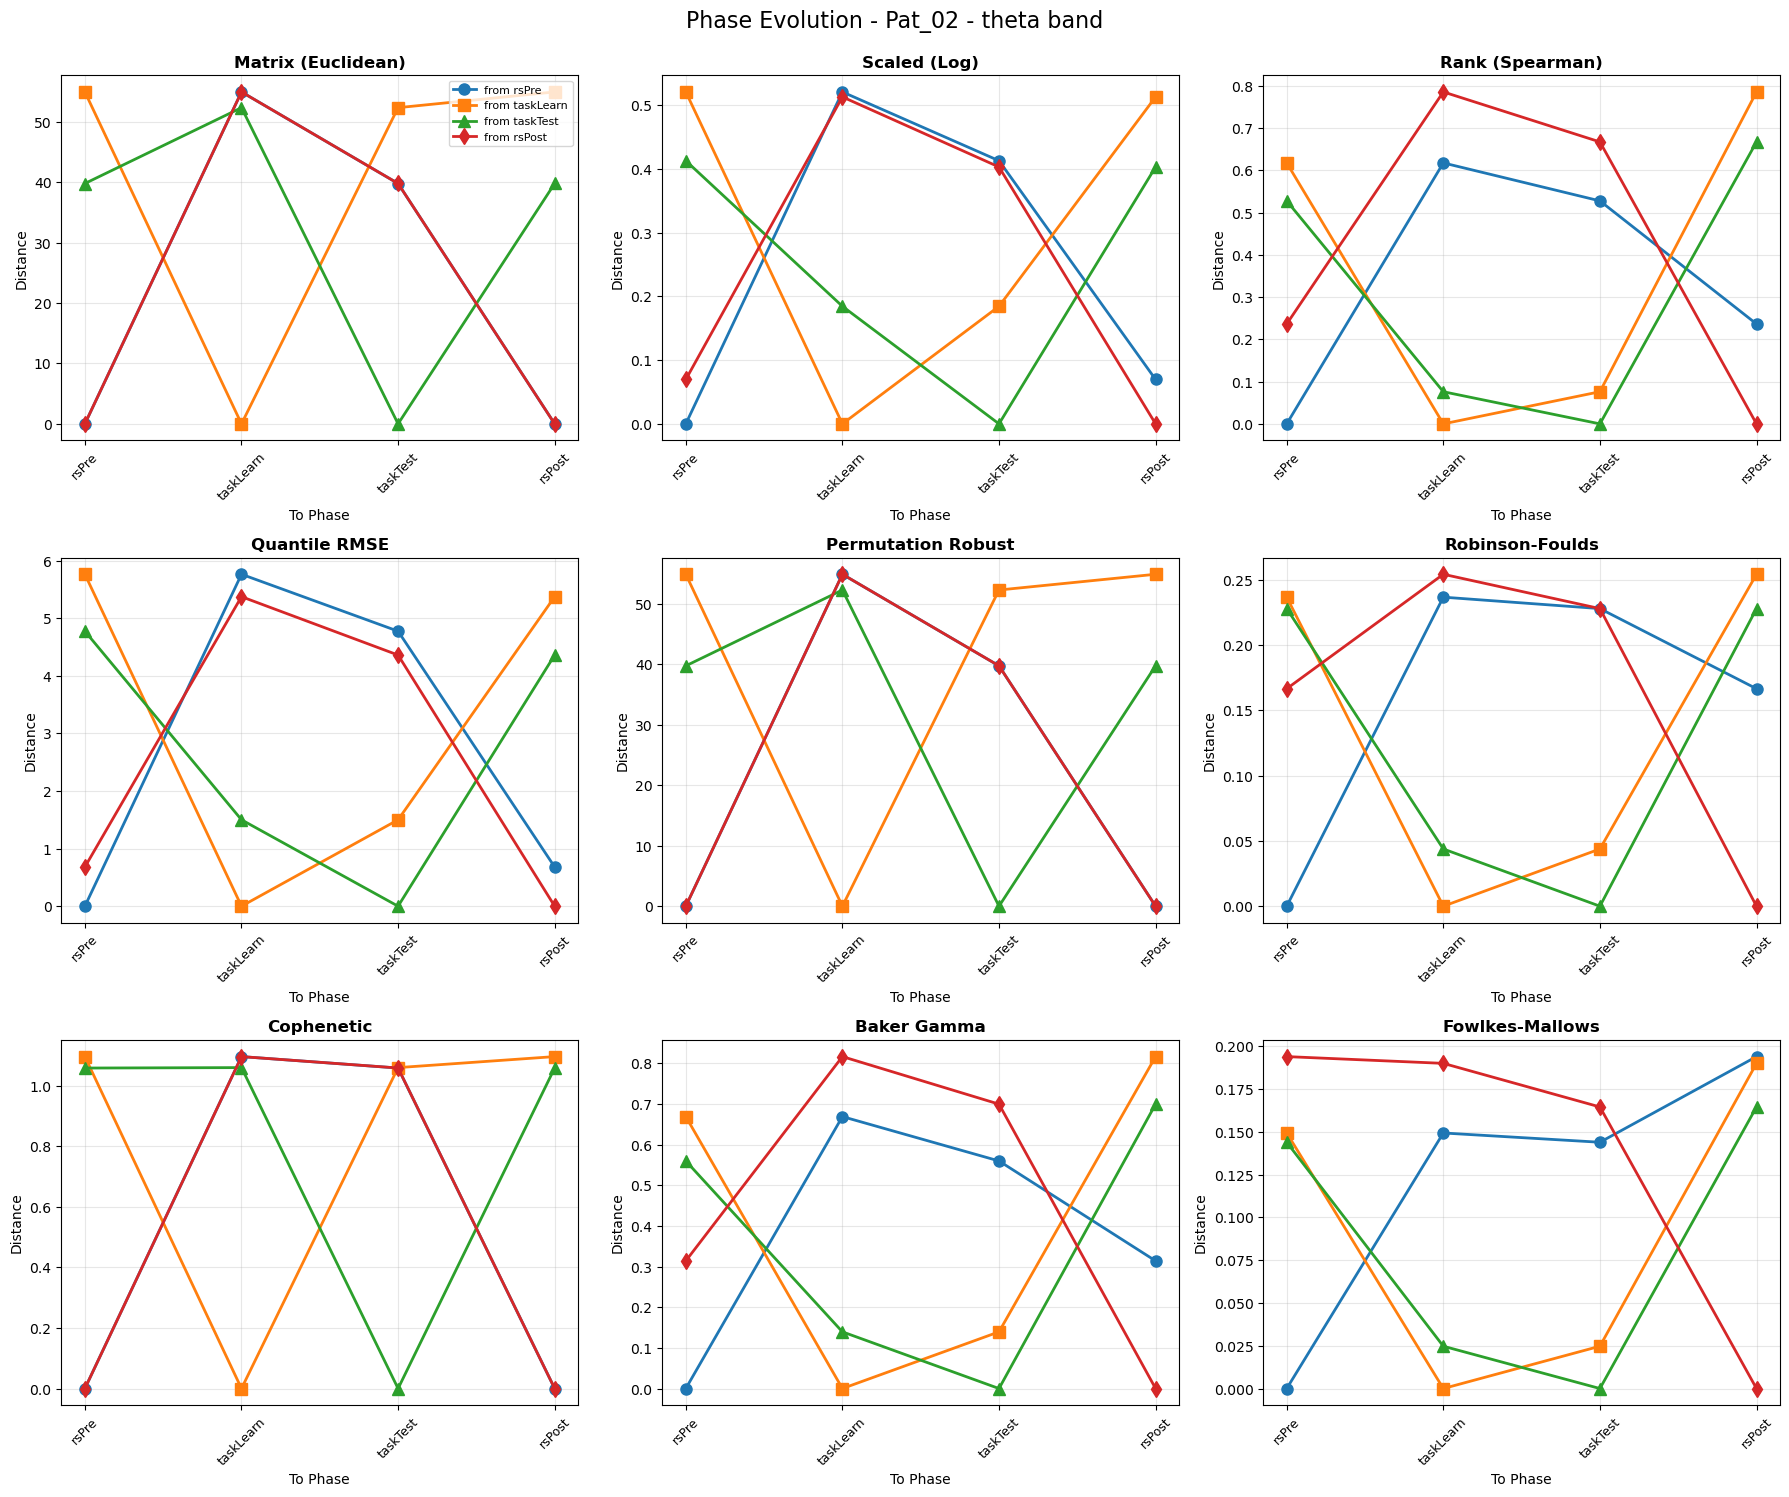

✓ Saved phase evolution plot to data/figures/new_distance_of_distances/phase_evolution_Pat_02_theta.png


In [60]:
# Phase evolution plots - show distance from each phase to all others
key_measures = {
    'Matrix (Euclidean)': all_measures['matrix_euclidean'],
    'Scaled (Log)': all_measures['scaled_log'],
    'Rank (Spearman)': all_measures['rank_spearman'],
    'Quantile RMSE': all_measures['quantile_rmse'],
    'Permutation Robust': all_measures['permutation_robust'],
    'Robinson-Foulds': all_measures['robinson_foulds'],
    'Cophenetic': all_measures['cophenetic_corr'],
    'Baker Gamma': all_measures['baker_gamma'],
    'Fowlkes-Mallows': all_measures['fowlkes_mallows'],
}

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'd']
labels = [f'from {ph}' for ph in phase_labels]

for idx, (measure_name, distance_matrix) in enumerate(key_measures.items()):
    ax = axes[idx]
    
    # Plot distances from each phase to all others
    for phase_idx in range(len(phase_labels)):
        ax.plot(np.arange(4), distance_matrix[phase_idx],
                color=colors[phase_idx], marker=markers[phase_idx],
                label=labels[phase_idx], linewidth=2, markersize=8, linestyle='-')
    
    ax.set_title(f'{measure_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Distance', fontsize=10)
    ax.set_xlabel('To Phase', fontsize=10)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(phase_labels, rotation=45, fontsize=9)
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend(loc='best', fontsize=8)

plt.suptitle(f'Phase Evolution - {patient} - {band} band', fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(path_figs / f'phase_evolution_{patient}_{band}.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"✓ Saved phase evolution plot to {path_figs / f'phase_evolution_{patient}_{band}.png'}")

Computing inter-measure correlations...


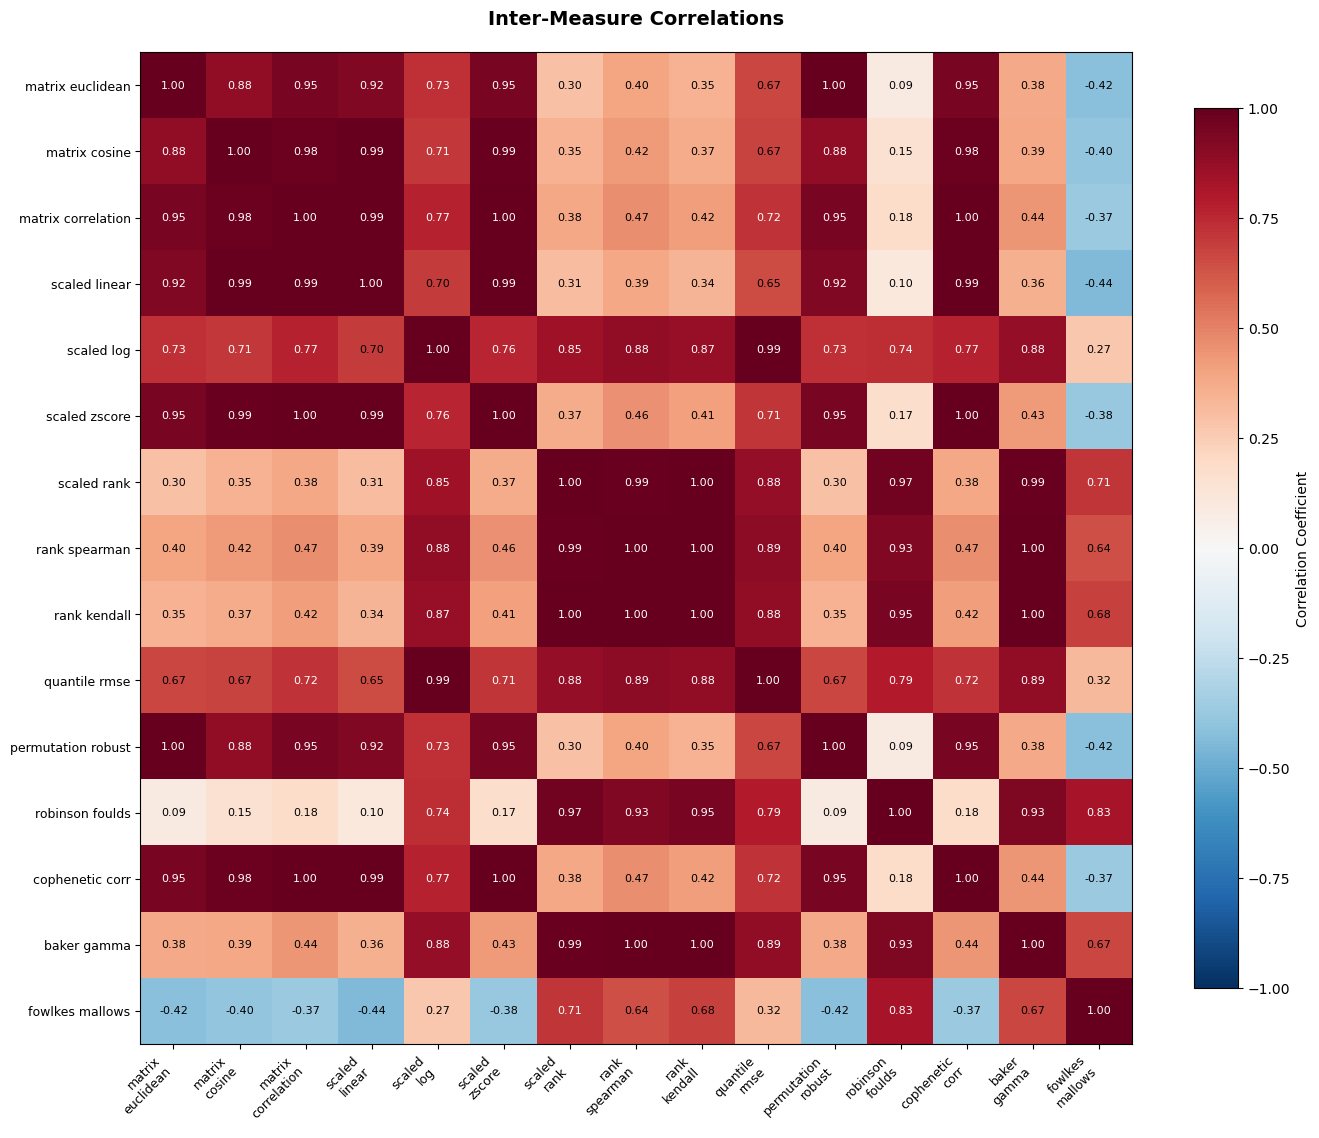

✓ Saved inter-measure correlation plot to data/figures/new_distance_of_distances/inter_measure_corr_Pat_02_theta.png

✓ All distance-of-distances measures computed and visualized!


In [61]:
# Inter-measure correlation analysis
measure_names = list(all_measures.keys())
n_measures = len(measure_names)
correlation_matrix = np.zeros((n_measures, n_measures))

print("Computing inter-measure correlations...")
for i, measure1 in enumerate(measure_names):
    for j, measure2 in enumerate(measure_names):
        if i == j:
            correlation_matrix[i, j] = 1.0
        else:
            # Get upper triangular values for both measures
            vals1 = all_measures[measure1][np.triu_indices_from(all_measures[measure1], k=1)]
            vals2 = all_measures[measure2][np.triu_indices_from(all_measures[measure2], k=1)]
            correlation_matrix[i, j] = np.corrcoef(vals1, vals2)[0, 1]

# Visualize inter-measure correlations
fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(n_measures))
ax.set_yticks(range(n_measures))
ax.set_xticklabels([name.replace('_', '\n') for name in measure_names], 
                    rotation=45, ha='right', fontsize=9)
ax.set_yticklabels([name.replace('_', ' ') for name in measure_names], fontsize=9)
ax.set_title('Inter-Measure Correlations', fontsize=14, fontweight='bold', pad=20)

# Add correlation values to cells
for i in range(n_measures):
    for j in range(n_measures):
        text_color = "white" if abs(correlation_matrix[i, j]) > 0.7 else "black"
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                      ha="center", va="center", color=text_color, fontsize=8)

plt.colorbar(im, ax=ax, shrink=0.8, label='Correlation Coefficient')
plt.tight_layout()
plt.savefig(path_figs / f'inter_measure_corr_{patient}_{band}.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"✓ Saved inter-measure correlation plot to {path_figs / f'inter_measure_corr_{patient}_{band}.png'}")
print("\n" + "="*70)
print("✓ All distance-of-distances measures computed and visualized!")

## Dendrogram Visualization

Visualize the hierarchical structures for each phase to understand the topological differences being quantified.

/tmp/ipykernel_11989/73457332.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


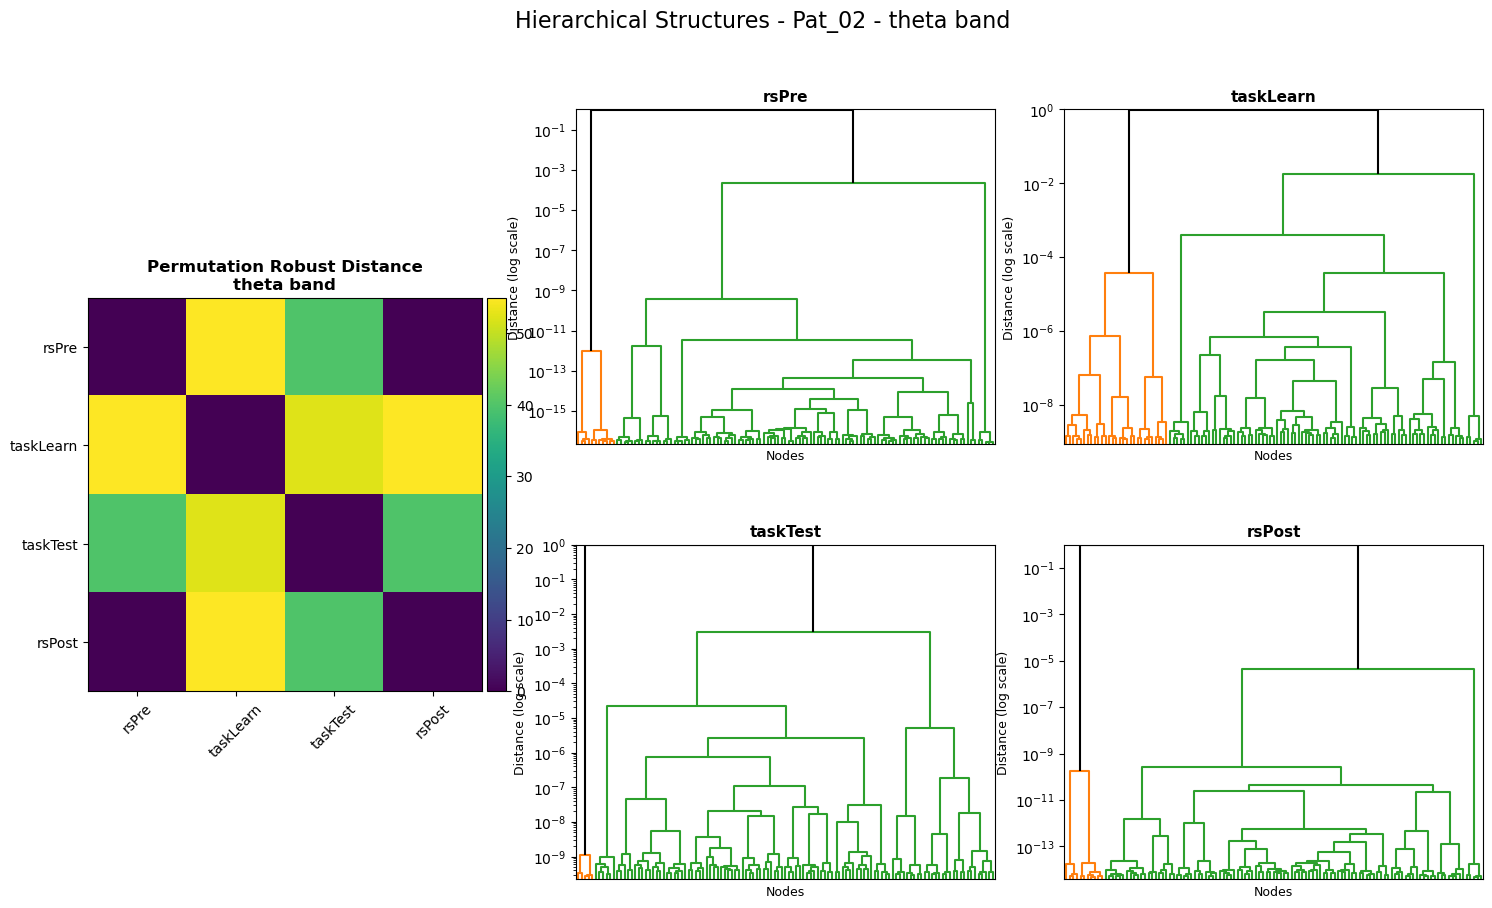

✓ Saved dendrogram comparison to data/figures/new_distance_of_distances/dendrograms_Pat_02_theta.png


In [62]:
# Visualize dendrograms for each phase alongside a representative distance matrix
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.4)

# Left subplot: Distance matrix (use permutation robust as representative)
ax_dist = fig.add_subplot(gs[:, 0:2])
distance_matrix = all_measures['permutation_robust']
im = ax_dist.imshow(distance_matrix, cmap='viridis', aspect='equal')
ax_dist.set_title(f'Permutation Robust Distance\n{band} band', fontsize=12, fontweight='bold')
ax_dist.set_xticks(range(len(phase_labels)))
ax_dist.set_yticks(range(len(phase_labels)))
ax_dist.set_xticklabels(phase_labels, rotation=45, fontsize=10)
ax_dist.set_yticklabels(phase_labels, fontsize=10)

# Add colorbar
div, cax, clb = imshow_colorbar_caxdivider(im, ax_dist)

# Right subplots: Dendrograms (2x2 grid)
for i, phase in enumerate(phase_labels):
    row = i // 2
    col = i % 2
    if col == 0:
        ax_dend = fig.add_subplot(gs[row, 2:4])
    else:
        ax_dend = fig.add_subplot(gs[row, 4:6])
    
    # Get linkage and condensed distance matrix
    lnkg = linkage_matrices[phase][band]
    cond_dists = cond_dist_matrices[phase][band]
    
    # Optimal leaf ordering
    Z_opt = optimal_leaf_ordering(lnkg, cond_dists)
    
    # Plot dendrogram
    dendrogram(Z_opt, ax=ax_dend, no_labels=True, **kw_dentro)
    ax_dend.set_yscale('log')
    
    # Set y-limits
    tmin = lnkg[:, 2][0] * 0.8
    tmax = lnkg[:, 2][-1] * 1.01
    ax_dend.set_ylim(tmin, tmax)
    ax_dend.set_title(f'{phase}', fontsize=11, fontweight='bold')
    ax_dend.set_xlabel('Nodes', fontsize=9)
    ax_dend.set_ylabel('Distance (log scale)', fontsize=9)

plt.suptitle(f'Hierarchical Structures - {patient} - {band} band', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig(path_figs / f'dendrograms_{patient}_{band}.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"✓ Saved dendrogram comparison to {path_figs / f'dendrograms_{patient}_{band}.png'}")

## Summary Statistics

Compute summary statistics for all measures.

In [63]:
import pandas as pd

# Calculate summary statistics for each measure
summary_stats = {}
for measure_name, distance_matrix in all_measures.items():
    # Get upper triangular values (exclude diagonal)
    triu_vals = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    summary_stats[measure_name] = {
        'mean': np.mean(triu_vals),
        'std': np.std(triu_vals),
        'min': np.min(triu_vals),
        'max': np.max(triu_vals),
        'median': np.median(triu_vals),
        'range': np.max(triu_vals) - np.min(triu_vals)
    }

# Convert to DataFrame for nice display
df_stats = pd.DataFrame(summary_stats).T
df_stats = df_stats[['mean', 'std', 'min', 'median', 'max', 'range']]

print("="*80)
print(f"SUMMARY STATISTICS - {patient} - {band} band")
print("="*80)
print(df_stats.to_string(float_format=lambda x: f'{x:.4f}'))
print("="*80)

# Find which measure shows the most/least variation
max_range_measure = df_stats['range'].idxmax()
min_range_measure = df_stats['range'].idxmin()

print(f"\nMost variation: {max_range_measure} (range = {df_stats.loc[max_range_measure, 'range']:.4f})")
print(f"Least variation: {min_range_measure} (range = {df_stats.loc[min_range_measure, 'range']:.4f})")

SUMMARY STATISTICS - Pat_02 - theta band
                      mean     std    min  median     max   range
matrix_euclidean   40.2898 19.1348 0.0049 46.0510 54.9291 54.9242
matrix_cosine       0.7261  0.3282 0.0000  0.8404  0.9307  0.9307
matrix_correlation  0.8952  0.4007 0.0000  1.0596  1.0967  1.0967
scaled_linear       0.5688  0.2552 0.0001  0.6751  0.7124  0.7123
scaled_log          0.3507  0.1676 0.0697  0.4081  0.5209  0.4513
scaled_zscore       0.6107  0.2732 0.0001  0.7279  0.7405  0.7404
scaled_rank         0.2309  0.0744 0.0955  0.2635  0.3083  0.2128
rank_spearman       0.4849  0.2489 0.0760  0.5724  0.7853  0.7093
rank_kendall        0.5679  0.2378 0.1566  0.6583  0.8418  0.6853
quantile_rmse       3.7408  1.9399 0.6802  4.5659  5.7611  5.0810
permutation_robust 40.2898 19.1348 0.0049 46.0510 54.9291 54.9242
robinson_foulds     0.1930  0.0720 0.0439  0.2281  0.2544  0.2105
cophenetic_corr     0.8952  0.4007 0.0000  1.0596  1.0967  1.0967
baker_gamma         0.5331  0.2346 

## Analysis Guide

### Measure Categories

**Direct Ultrametric Comparisons:**
- `matrix_*`: Direct comparison of ultrametric values
- `scaled_*`: Scale-normalized comparisons (log, zscore, rank)
- **Use when:** Comparing absolute hierarchical structures

**Ordinal Comparisons:**
- `rank_*`: Spearman/Kendall rank correlations
- **Use when:** Interested in ordering relationships, not magnitudes

**Distributional Comparisons:**
- `quantile_rmse`: Compares distributions across scales
- **Use when:** Analyzing multiscale properties

**Permutation-Invariant:**
- `permutation_robust`: Handles node ordering differences
- **Use when:** Node labels may differ or be arbitrary

**Tree Topology:**
- `robinson_foulds`: Pure topological comparison (splits)
- `cophenetic_corr`: Linear correlation of cophenetic distances
- `baker_gamma`: Concordance of hierarchical relationships
- `fowlkes_mallows`: Precision-recall metric
- **Use when:** Focusing on dendrogram structure

### Interpretation
- **Low distance** → similar hierarchical organization
- **High distance** → different network structures
- **High inter-measure correlation** → measures capture similar aspects